In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn,optim
from torch.autograd import Variable
from torchvision import transforms, datasets

# AutoEncoder안의 잠재변수를 알아보자
AutoEncoder로 학습을 돌렸을 때 같은 옷들이 어디 분포해 있는지 시각화해보자!!
---

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3차원 좌표를 그리는 용도
from matplotlib import cm #데이터 포인트에 색상을 입히는 용도
import numpy as np

In [3]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [4]:
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw



In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        #특징점을 압축하는 인코더!!
        self.encoder = nn.Sequential( #레이어들을 하나로 묶어주는 Sequential함수
            nn.Linear(28*28,128), #784 -> 128
            nn.ReLU(),
            nn.Linear(128,64), #128 -> 64
            nn.ReLU(),
            nn.Linear(64,12), # 64 -> 12
            nn.ReLU(),
            nn.Linear(12,3) # 12 -> 3
        )
        
        #압축된 형태를 푸는 디코더!!
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid() #출력값을 0과 1 사이로 만들어주는 시그모이드!!
        )
        
    def forward(self,x):
        encoded =self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(),lr = 0.005) #옵티마이저는 아담!!
criterion = nn.MSELoss() #픽셀별 차이의 제곱평균을 구하기 위해 criterion은 평균제곱오차!

In [7]:
view_data = trainset.data[:5].view(-1,28*28) #데이터를 시각화하기 위해 뽑아서 1채널로 바꾸기
view_data = view_data.type(torch.FloatTensor)/255. #모델이 인식할 수 있게 픽셀 값을 0 ~ 1 사이로 바꾸기

In [8]:
def train(autoencoder,train_loader):
    autoencoder.train()
    for step,(x,label) in enumerate(train_loader):
        x = x.view(-1,28*28).to(DEVICE)
        y = x.view(-1,28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        loss = criterion(decoded,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [9]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

여기서부터 시각화 시작!!
---

In [10]:
view_data = trainset.train_data[:200].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

c:\python38\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [11]:
## 시각화를 위한 라벨링!!
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

C:\Users\USER\AppData\Local\Temp\ipykernel_4724\3487894646.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
c:\python38\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


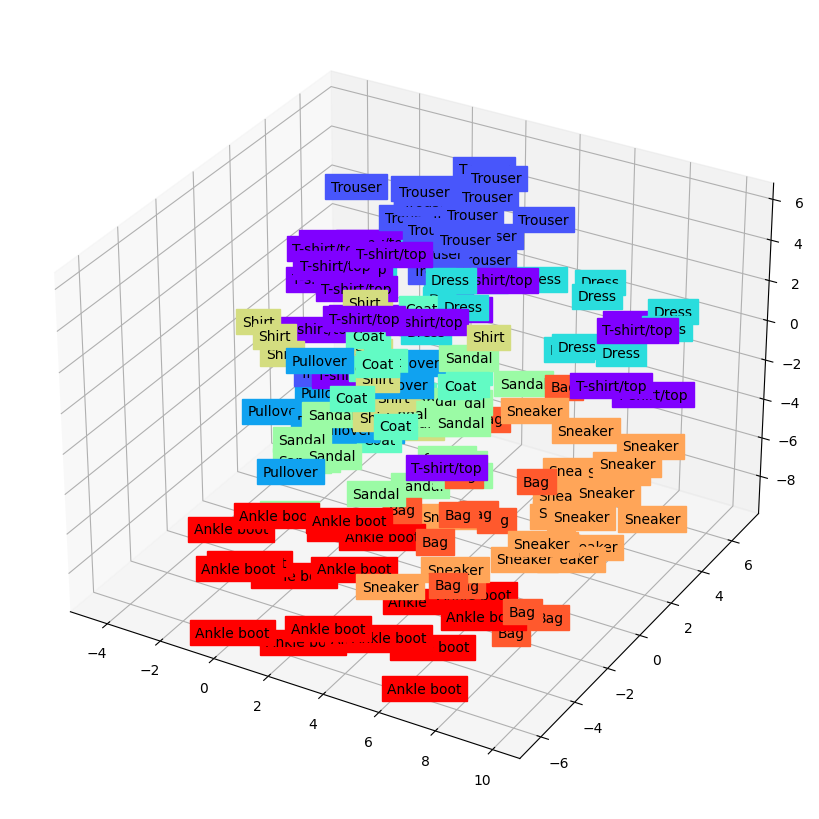

In [12]:
fig = plt.figure(figsize = (10,8))
ax = Axes3D(fig)

#3채널로 뽑힌 값들을 XYZ에 넣어주기
X = encoded_data.data[:,0].numpy() 
Y = encoded_data.data[:,1].numpy()
Z = encoded_data.data[:,2].numpy()

labels = trainset.train_labels[:200].numpy()

for x,y,z,s in zip(X ,Y,Z,labels): #zip함수는 배열들의 각 행마다 맵핑을 시킵니다. (1,2,3),(a,b,c) = (1,a),(2,b),(3,c)
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z,name, backgroundcolor = color)
    
ax.set_xlim(X.min(),X.max())
ax.set_ylim(Y.min(),Y.max())
ax.set_zlim(Z.min(),Z.max())
plt.show()

같은 집단끼리 모여있고, 그 위로는 신발, 옷 등의 큰 카테고리 별로 묶여있는것을 볼 수 있다..!
---